In [5]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib
import IPython
import IPython.display
from sklearn.linear_model import LinearRegression

In [6]:
data = yf.download('0005.hk')
data.head()
data['Prediction']=data['Close'].shift(-1)
data.drop('Adj Close',1,inplace=True)
data.dropna(inplace=True)
data.isnull().sum()

[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_26974/3551886566.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('Adj Close',1,inplace=True)


Open          0
High          0
Low           0
Close         0
Volume        0
Prediction    0
dtype: int64

In [7]:
#Create a data set X and convert it into numpy array , which will be having actual values
X = np.array(data.drop(['Prediction'],1))
print(X)
# Create a dataset y which will be having Predicted values and convert into numpy array
y = np.array(data['Prediction'])
print(y)

[[1.11000000e+02 1.11500000e+02 1.07500000e+02 1.08000000e+02
  3.90816400e+06]
 [1.06000000e+02 1.06500000e+02 1.05000000e+02 1.06000000e+02
  6.89537800e+06]
 [1.01000000e+02 1.02000000e+02 9.95000000e+01 1.00500000e+02
  1.46570980e+07]
 ...
 [5.85000000e+01 5.87999992e+01 5.83499985e+01 5.87999992e+01
  2.90304180e+07]
 [5.90000000e+01 5.95499992e+01 5.89000015e+01 5.92999992e+01
  3.09088590e+07]
 [5.87999992e+01 5.89000015e+01 5.80000000e+01 5.87500000e+01
  1.81124180e+07]]
[106.         100.5         97.         ...  59.29999924  58.75
  59.        ]


/tmp/ipykernel_26974/3194755090.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(data.drop(['Prediction'],1))


In [8]:
# Split the data into train and test with 90 & 10 % respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_nn=X_train.reshape(X_train.shape[0],1,5)
X_test_nn=X_test.reshape(X_test.shape[0],1,5)

In [10]:
normalizer=tf.keras.layers.Normalization(axis=-1)
linear = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=1,
                           input_shape=(X_train_nn.shape[1],X_train_nn.shape[2])
                           ),
    tf.keras.layers.MaxPool1D(1),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1),
],name="Conv")
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128,return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(units=64),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


2022-02-14 09:07:28.884189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-02-14 09:07:28.884647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 09:07:28.884725: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-02-14 09:07:28.884761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-02-14 09:07:28.884789: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [11]:
models=[linear,conv_model,lstm_model]
history={}
val_performance={}
performance={}
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    mode='min')
for model in models:
    IPython.display.clear_output()
    print(model.name)
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    if model.name == "Linear":
        history[model.name]=model.fit(X_train,y_train,epochs=600,validation_data=(X_test,y_test),shuffle=False)
        val_performance[model.name] = model.evaluate(X_test,y_test)
        performance[model.name] = model.evaluate(X_test,y_test, verbose=0)
    else:
        history[model.name]=model.fit(X_train_nn,y_train,epochs=300,validation_data=(X_test_nn,y_test),shuffle=False)
        val_performance[model.name] = model.evaluate(X_test_nn,y_test)
        performance[model.name] = model.evaluate(X_test_nn,y_test, verbose=0)



sequential_1
Epoch 1/300


139/139 [==============================] - 3s 6ms/step - loss: 3950.2732 - mean_absolute_error: 51.8882 - val_loss: 831.0341 - val_mean_absolute_error: 22.9740
Epoch 2/300
139/139 [==============================] - 0s 3ms/step - loss: 810.5754 - mean_absolute_error: 22.6856 - val_loss: 829.6224 - val_mean_absolute_error: 22.6126
Epoch 3/300
139/139 [==============================] - 0s 3ms/step - loss: 808.9084 - mean_absolute_error: 22.6639 - val_loss: 827.7592 - val_mean_absolute_error: 22.5783
Epoch 4/300
139/139 [==============================] - 0s 3ms/step - loss: 808.7308 - mean_absolute_error: 22.6657 - val_loss: 826.7460 - val_mean_absolute_error: 22.5758
Epoch 5/300
139/139 [==============================] - 0s 3ms/step - loss: 807.3079 - mean_absolute_error: 22.6273 - val_loss: 825.3190 - val_mean_absolute_error: 22.5761
Epoch 6/300
139/139 [==============================] - 0s 3ms/step - loss: 807.8698 - mean_absolute_error: 22.6379 - val_loss: 826.9890 - val_mean_absolute_

<function matplotlib.pyplot.show(close=None, block=None)>

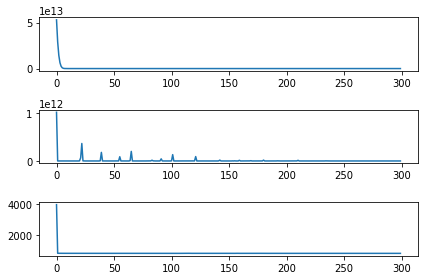

In [12]:
fig, ax = plt.subplots(len(models))
cur=0
for model in models:
    modelHistory=None
    if model.name == "Linear":
        modelHistory=history[model.name]
    else:
        modelHistory=history[model.name]
    ax[cur].plot(modelHistory.history['loss'], label='train')
    cur+=1
fig.tight_layout()
plt.show

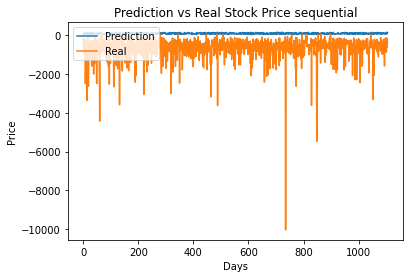

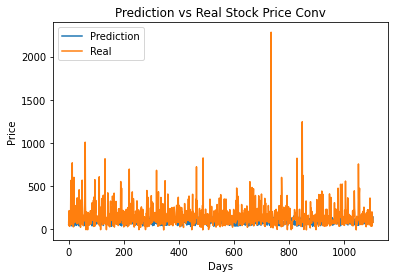

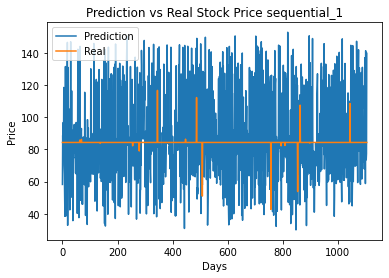

In [14]:
for model in models:
    prediction=[]
    if model.name == "Linear":
        prediction=model.predict(X_test)
    else:
        prediction=model.predict(X_test_nn)
    plt.figure()
    plt.plot(y_test)
    plt.plot(prediction.reshape(prediction.size,1))
    plt.title('Prediction vs Real Stock Price '+model.name)
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='upper left')